In [84]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import pandas as pd
import json
import pymysql
from datetime import timedelta, date
import os
import sys
import urllib.request
import re

import pymysql
import numpy as np
import pickle
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


In [2]:
def getEcosAPI(API_KEY, code, max, start_month, end_month):
    url = 'http://ecos.bok.or.kr/api/StatisticSearch/%s/json/kr/1/%s/%s/MM/%s/%s/?/?/?/' % (API_KEY, max, code, start_month, end_month)
    result = urlopen(url)
    html = result.read()
    
    return json.loads(html)

In [9]:
API_KEY = "YOUR_API_KEY"
data = getEcosAPI(API_KEY, code = '040Y002', max = 100000, start_month = '200801', end_month = '202011')

In [10]:
data = data["StatisticSearch"]["row"]
produce = pd.DataFrame(data)

ccsi = produce[produce['ITEM_CODE1'] == 'FME']
ccsi = ccsi.loc[:, ['TIME', 'DATA_VALUE']].reset_index(drop=True)
ccsi

,TIME,DATA_VALUE
0,200807,73.7
1,200808,91.8
2,200809,90.6
3,200810,77.9
4,200811,72.9
...,...,...
144,202007,84.2
145,202008,88.2
146,202009,79.4
147,202010,91.6


## DB 연결

In [77]:
conn = pymysql.connect(host = "127.0.0.1", user = [USER], passwd = [PASSWORD], db = [DATABASE])
cur = conn.cursor()
cur.execute("use crawling")

0

**CCSI**

In [28]:
create_table_query = """
CREATE TABLE IF NOT EXISTS ccsi_final(
    id BIGINT(7) NOT NULL AUTO_INCREMENT,
    year bigint(4) NOT NULL,
    month bigint(2) NOT NULL,
    ccsi double,
    primary key(id) )
    charset=utf8mb4;
"""
cur.execute(create_table_query)

/home/chaelin/anaconda3/lib/python3.8/site-packages/pymysql/cursors.py:329: Warning: (1050, "Table 'ccsi_final' already exists")
  self._do_get_result()


0

In [30]:
def extract_year_and_month(period):
    year = period[0:4]
    month = period[4:6]
    return year, month

In [32]:
for i in range(len(ccsi)):
    query = """ 
    Insert into ccsi_final (year, month, ccsi) values (%d, %d, %f) ;
    """
    year, month = extract_year_and_month(ccsi.iloc[i].TIME)
    ccsi_value = ccsi.iloc[i].DATA_VALUE

    mystring = (query % (int(year), int(month), float(ccsi_value)))
    cur.execute(mystring)

**naver**

In [44]:
client_id = "YOUR_CLIENT_ID"
client_secret = "YOUR_CLIENT_SECRET"

start_date = '2016-01-01'
today = date.today().strftime('%Y-%m-%d')
url = "https://openapi.naver.com/v1/datalab/search";
body = "{\"startDate\":\""+start_date+"\",\"endDate\":\""+today+"\",\"timeUnit\":\"week\",\"keywordGroups\":[{\"groupName\":\"경제\",\"keywords\":[\"경제\"]}]}";

request = urllib.request.Request(url)
request.add_header("X-Naver-Client-Id",client_id)
request.add_header("X-Naver-Client-Secret",client_secret)
request.add_header("Content-Type","application/json")
response = urllib.request.urlopen(request, data=body.encode("utf-8"))
rescode = response.getcode()
if(rescode==200):
    response_body = response.read()
    scrapped = response_body.decode('utf-8')
else:
    print("Error Code:" + rescode)

In [45]:
jsonResult = json.loads(scrapped)
jsonResult['results'][0]['data']

[{'period': '2015-12-28', 'ratio': 19.65163},
 {'period': '2016-01-04', 'ratio': 26.05846},
 {'period': '2016-01-11', 'ratio': 25.16599},
 {'period': '2016-01-18', 'ratio': 27.38639},
 {'period': '2016-01-25', 'ratio': 24.72622},
 {'period': '2016-02-01', 'ratio': 23.01888},
 {'period': '2016-02-08', 'ratio': 23.62248},
 {'period': '2016-02-15', 'ratio': 25.2824},
 {'period': '2016-02-22', 'ratio': 23.76476},
 {'period': '2016-02-29', 'ratio': 28.85228},
 {'period': '2016-03-07', 'ratio': 31.58144},
 {'period': '2016-03-14', 'ratio': 28.44701},
 {'period': '2016-03-21', 'ratio': 26.88626},
 {'period': '2016-03-28', 'ratio': 26.26972},
 {'period': '2016-04-04', 'ratio': 25.94205},
 {'period': '2016-04-11', 'ratio': 25.57126},
 {'period': '2016-04-18', 'ratio': 26.74829},
 {'period': '2016-04-25', 'ratio': 25.11425},
 {'period': '2016-05-02', 'ratio': 22.536},
 {'period': '2016-05-09', 'ratio': 27.78304},
 {'period': '2016-05-16', 'ratio': 27.96412},
 {'period': '2016-05-23', 'ratio': 29

In [46]:
navertrends_df = pd.DataFrame(jsonResult['results'][0]['data'])
navertrends_df = navertrends_df.rename({'period': 'date', 'ratio':'naver'}, axis = 'columns')
navertrends_df

,date,naver
0,2015-12-28,19.65163
1,2016-01-04,26.05846
2,2016-01-11,25.16599
3,2016-01-18,27.38639
4,2016-01-25,24.72622
...,...,...
252,2020-10-26,30.24489
253,2020-11-02,30.02069
254,2020-11-09,30.88298
255,2020-11-16,30.48202


**google**

In [47]:
googletrends_df = pd.read_csv('./data/googletrend_final.csv', header=1, sep=',', skip_blank_lines = True)
googletrends_df = googletrends_df.rename({'주': 'date', '경제: (대한민국)':'google'}, axis = 'columns')

In [48]:
def plus_one_day(googletrends_df):
    date2 = []
    for i in range(len(googletrends_df)):
        after_one_day = datetime.strptime(googletrends_df.iloc[i].date, '%Y-%m-%d').date() + timedelta(days=1)
        after_one_day = after_one_day.strftime("%Y-%m-%d")
        date2.append(after_one_day)
    return date2

googletrends_df['date'] = plus_one_day(googletrends_df)
googletrends_df

,date,google
0,2015-10-05,65
1,2015-10-12,72
2,2015-10-19,79
3,2015-10-26,77
4,2015-11-02,68
...,...,...
264,2020-10-26,76
265,2020-11-02,73
266,2020-11-09,81
267,2020-11-16,85


In [49]:
portaltrends_df = pd.merge(googletrends_df, navertrends_df, how='left')
portaltrends_df = portaltrends_df.fillna(0)
portaltrends_df

,date,google,naver
0,2015-10-05,65,0.00000
1,2015-10-12,72,0.00000
2,2015-10-19,79,0.00000
3,2015-10-26,77,0.00000
4,2015-11-02,68,0.00000
...,...,...,...
264,2020-10-26,76,30.24489
265,2020-11-02,73,30.02069
266,2020-11-09,81,30.88298
267,2020-11-16,85,30.48202


In [50]:
def extract_year_and_month_day(period):
    year = period.split('-')[0]
    month = period.split('-')[1]
    day = period.split('-')[2]
    return year, month, day

In [56]:
create_table_query = """
CREATE TABLE IF NOT EXISTS portal_trends_ratio_final(
    id BIGINT(7) NOT NULL AUTO_INCREMENT,
    year bigint(4) NOT NULL,
    month bigint(2) NOT NULL,
    day bigint(2) NOT NULL,
    google double,
    naver double,
    primary key(id) )
    charset=utf8mb4;
"""
cur.execute(create_table_query)

0

In [57]:
for i in range(len(portaltrends_df)):
    query = """ 
    Insert into portal_trends_ratio_final (year, month, day, google, naver) values (%d, %d, %d, %f, %f) ;
    """
    year, month, day = extract_year_and_month_day(portaltrends_df.iloc[i].date)
    google_cnt = portaltrends_df.iloc[i].google
    naver_cnt = portaltrends_df.iloc[i].naver

    mystring = (query % (int(year), int(month), int(day), float(google_cnt), float(naver_cnt)))
    print(mystring)
    cur.execute(mystring)

 
    Insert into portal_trends_ratio_final (year, month, day, google, naver) values (2015, 10, 5, 65.000000, 0.000000) ;
    
 
    Insert into portal_trends_ratio_final (year, month, day, google, naver) values (2015, 10, 12, 72.000000, 0.000000) ;
    
 
    Insert into portal_trends_ratio_final (year, month, day, google, naver) values (2015, 10, 19, 79.000000, 0.000000) ;
    
 
    Insert into portal_trends_ratio_final (year, month, day, google, naver) values (2015, 10, 26, 77.000000, 0.000000) ;
    
 
    Insert into portal_trends_ratio_final (year, month, day, google, naver) values (2015, 11, 2, 68.000000, 0.000000) ;
    
 
    Insert into portal_trends_ratio_final (year, month, day, google, naver) values (2015, 11, 9, 66.000000, 0.000000) ;
    
 
    Insert into portal_trends_ratio_final (year, month, day, google, naver) values (2015, 11, 16, 70.000000, 0.000000) ;
    
 
    Insert into portal_trends_ratio_final (year, month, day, google, naver) values (2015, 11, 23, 79.0000

 
    Insert into portal_trends_ratio_final (year, month, day, google, naver) values (2017, 10, 30, 63.000000, 25.743720) ;
    
 
    Insert into portal_trends_ratio_final (year, month, day, google, naver) values (2017, 11, 6, 61.000000, 25.614380) ;
    
 
    Insert into portal_trends_ratio_final (year, month, day, google, naver) values (2017, 11, 13, 60.000000, 24.191600) ;
    
 
    Insert into portal_trends_ratio_final (year, month, day, google, naver) values (2017, 11, 20, 58.000000, 25.963610) ;
    
 
    Insert into portal_trends_ratio_final (year, month, day, google, naver) values (2017, 11, 27, 65.000000, 27.658010) ;
    
 
    Insert into portal_trends_ratio_final (year, month, day, google, naver) values (2017, 12, 4, 60.000000, 26.136060) ;
    
 
    Insert into portal_trends_ratio_final (year, month, day, google, naver) values (2017, 12, 11, 60.000000, 22.880910) ;
    
 
    Insert into portal_trends_ratio_final (year, month, day, google, naver) values (2017, 12, 18,

 
    Insert into portal_trends_ratio_final (year, month, day, google, naver) values (2019, 12, 9, 71.000000, 24.450280) ;
    
 
    Insert into portal_trends_ratio_final (year, month, day, google, naver) values (2019, 12, 16, 59.000000, 24.545140) ;
    
 
    Insert into portal_trends_ratio_final (year, month, day, google, naver) values (2019, 12, 23, 52.000000, 21.552980) ;
    
 
    Insert into portal_trends_ratio_final (year, month, day, google, naver) values (2019, 12, 30, 54.000000, 22.445460) ;
    
 
    Insert into portal_trends_ratio_final (year, month, day, google, naver) values (2020, 1, 6, 56.000000, 24.036380) ;
    
 
    Insert into portal_trends_ratio_final (year, month, day, google, naver) values (2020, 1, 13, 58.000000, 23.566430) ;
    
 
    Insert into portal_trends_ratio_final (year, month, day, google, naver) values (2020, 1, 20, 51.000000, 21.074410) ;
    
 
    Insert into portal_trends_ratio_final (year, month, day, google, naver) values (2020, 1, 27, 52.

**keywords**

In [61]:
news_df = pd.read_json('./data/bigkinds_final.json')
news_df

,date,침체,금융위기,불황,폭락,외환위기
0,20150907,737,399,273,236,135
1,20150914,701,513,274,147,226
2,20150921,575,267,231,216,111
3,20150928,480,248,173,129,79
4,20151005,576,262,204,87,109
...,...,...,...,...,...,...
268,20201026,992,198,178,187,114
269,20201102,866,158,143,122,63
270,20201109,907,150,141,137,95
271,20201116,822,131,143,91,82


In [62]:
def getDate(df_row):
    date = str(df_row)
    year = date[0:4]
    month = date[4:6]
    day = date[6:9]
    return int(year), int(month), int(day)

In [65]:
create_table_query = """
CREATE TABLE IF NOT EXISTS news_counting_final(
    id BIGINT(7) NOT NULL AUTO_INCREMENT,
    year bigint(4) NOT NULL,
    month bigint(2) NOT NULL,
    day bigint(2) NOT NULL, 
    keyword1 bigint(100),
    keyword2 bigint(100),
    keyword3 bigint(100),
    keyword4 bigint(100),
    keyword5 bigint(100),
    primary key(id) )
    charset=utf8mb4;
"""
cur.execute(create_table_query)
# charset=utf8mb4; 유니코드 스트링 저장

0

In [66]:
for i in range(len(news_df)):
    query = """ 
    Insert into news_counting_final (year, month, day, keyword1, keyword2, keyword3, keyword4, keyword5 ) values (%d, %d, %d, %d, %d, %d, %d, %d) ;
    """
    year, month, day = getDate(news_df.iloc[i]['date'])
    keyword1_cnt = news_df.iloc[i]['침체']
    keyword2_cnt = news_df.iloc[i]['금융위기']
    keyword3_cnt = news_df.iloc[i]['불황']
    keyword4_cnt = news_df.iloc[i]['폭락']
    keyword5_cnt = news_df.iloc[i]['외환위기']

    mystring = ( query % (year, month, day, keyword1_cnt, keyword2_cnt, keyword3_cnt, keyword4_cnt, keyword5_cnt) )
    print(mystring)
    cur.execute(mystring)

 
    Insert into news_counting_final (year, month, day, keyword1, keyword2, keyword3, keyword4, keyword5 ) values (2015, 9, 7, 737, 399, 273, 236, 135) ;
    
 
    Insert into news_counting_final (year, month, day, keyword1, keyword2, keyword3, keyword4, keyword5 ) values (2015, 9, 14, 701, 513, 274, 147, 226) ;
    
 
    Insert into news_counting_final (year, month, day, keyword1, keyword2, keyword3, keyword4, keyword5 ) values (2015, 9, 21, 575, 267, 231, 216, 111) ;
    
 
    Insert into news_counting_final (year, month, day, keyword1, keyword2, keyword3, keyword4, keyword5 ) values (2015, 9, 28, 480, 248, 173, 129, 79) ;
    
 
    Insert into news_counting_final (year, month, day, keyword1, keyword2, keyword3, keyword4, keyword5 ) values (2015, 10, 5, 576, 262, 204, 87, 109) ;
    
 
    Insert into news_counting_final (year, month, day, keyword1, keyword2, keyword3, keyword4, keyword5 ) values (2015, 10, 12, 541, 255, 234, 162, 77) ;
    
 
    Insert into news_counting_final

 
    Insert into news_counting_final (year, month, day, keyword1, keyword2, keyword3, keyword4, keyword5 ) values (2017, 6, 12, 377, 253, 192, 72, 111) ;
    
 
    Insert into news_counting_final (year, month, day, keyword1, keyword2, keyword3, keyword4, keyword5 ) values (2017, 6, 19, 344, 141, 176, 116, 90) ;
    
 
    Insert into news_counting_final (year, month, day, keyword1, keyword2, keyword3, keyword4, keyword5 ) values (2017, 6, 26, 412, 154, 198, 95, 85) ;
    
 
    Insert into news_counting_final (year, month, day, keyword1, keyword2, keyword3, keyword4, keyword5 ) values (2017, 7, 3, 389, 220, 188, 86, 90) ;
    
 
    Insert into news_counting_final (year, month, day, keyword1, keyword2, keyword3, keyword4, keyword5 ) values (2017, 7, 10, 413, 182, 196, 94, 72) ;
    
 
    Insert into news_counting_final (year, month, day, keyword1, keyword2, keyword3, keyword4, keyword5 ) values (2017, 7, 17, 344, 158, 156, 100, 78) ;
    
 
    Insert into news_counting_final (year,

 
    Insert into news_counting_final (year, month, day, keyword1, keyword2, keyword3, keyword4, keyword5 ) values (2019, 4, 1, 891, 195, 250, 113, 111) ;
    
 
    Insert into news_counting_final (year, month, day, keyword1, keyword2, keyword3, keyword4, keyword5 ) values (2019, 4, 8, 710, 246, 217, 136, 105) ;
    
 
    Insert into news_counting_final (year, month, day, keyword1, keyword2, keyword3, keyword4, keyword5 ) values (2019, 4, 15, 645, 202, 160, 74, 83) ;
    
 
    Insert into news_counting_final (year, month, day, keyword1, keyword2, keyword3, keyword4, keyword5 ) values (2019, 4, 22, 796, 385, 184, 85, 141) ;
    
 
    Insert into news_counting_final (year, month, day, keyword1, keyword2, keyword3, keyword4, keyword5 ) values (2019, 4, 29, 645, 261, 204, 58, 127) ;
    
 
    Insert into news_counting_final (year, month, day, keyword1, keyword2, keyword3, keyword4, keyword5 ) values (2019, 5, 6, 685, 242, 190, 179, 113) ;
    
 
    Insert into news_counting_final (ye

**data 가져오기**

In [106]:
query = """ 
select * from news_counting_final ;
"""
cur.execute(query)
news_df = pd.DataFrame(list(cur.fetchall())).drop(['id'], axis=1)
news_df.head()

query = """ 
select * from portal_trends_ratio_final ;
"""
cur.execute(query)
portal_df = pd.DataFrame(list(cur.fetchall()))
portal_df = portal_df[['year', 'month', 'day', 'google', 'naver']][13:]

query = """ 
select * from ccsi_final ;
"""
cur.execute(query)
# X와 기간을 맞춤
ccsi_final = pd.DataFrame(list(cur.fetchall()))[90:].reset_index(drop = True)

In [67]:
conn.commit()
cur.close()
conn.close()

In [107]:
predictors_final = pd.merge(news_df, portal_df)
predictors_final

,year,month,day,keyword1,keyword2,keyword3,keyword4,keyword5,google,naver
0,2016,1,4,825,419,437,986,168,53.0,26.05846
1,2016,1,11,770,348,351,626,182,56.0,25.16599
2,2016,1,18,918,422,441,445,147,71.0,27.38639
3,2016,1,25,1067,425,567,383,148,62.0,24.72622
4,2016,2,1,899,341,485,289,110,54.0,23.01888
...,...,...,...,...,...,...,...,...,...,...
251,2020,10,26,992,198,178,187,114,76.0,30.24489
252,2020,11,2,866,158,143,122,63,73.0,30.02069
253,2020,11,9,907,150,141,137,95,81.0,30.88298
254,2020,11,16,822,131,143,91,82,85.0,30.48202


## final model - random forest

In [97]:
def pickleLoad(file):
    if os.path.isfile(file):        
        with open(file,"rb") as fr:
            dataframe = pickle.load(fr)
        return dataframe
    else:  
        %run -i './getTrainTestSet/getTrainTestSet_interpolation.py'

In [132]:
# load train, test set data

X_train = pickleLoad('./dataset/dataset_interpolation/X_train.pkl')
X_test = pickleLoad('./dataset/dataset_interpolation/X_test.pkl')
y_train = pickleLoad('./dataset/dataset_interpolation/y_train.pkl')
y_test = pickleLoad('./dataset/dataset_interpolation/y_test.pkl')
ccsi = pickleLoad('./dataset/dataset_interpolation/ccsi.pkl')
predictors = pickleLoad('./dataset/dataset_interpolation/predictors.pkl')

In [133]:
# 변수 스케일링
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test= scaler.transform(X_test)
X = scaler.transform(predictors_final.loc[:, ['keyword1', 'keyword2', 'keyword3', 'keyword4', 'keyword5', 'google', 'naver']])


In [134]:
model_forest = RandomForestRegressor(n_estimators=32, max_features=4, random_state=23, warm_start=True)
model_forest.fit(X_train, y_train)
y_pred = model_forest.predict(X_test)

<ipython-input-134-a2f7ade1a5e2>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_forest.fit(X_train, y_train)


In [135]:
pred_ccsi = model_forest.predict(X)

In [142]:
def isLastWeekOfThisMonth(X, index):
    if(index == (len(X) - 1)):
        return True
    if ( X.iloc[index].month != X.iloc[index + 1].month ):
        return True
    return False

def getYdataframe(X, y):
    count = 0
    y_weekly = pd.DataFrame()

    for i in range(len(X)):
        count+= 1

        if ( isLastWeekOfThisMonth(X, i) ):
            a = np.where((y.month == X.iloc[i].month) & (y.year == X.iloc[i].year ))[0]
            present_ccsi = float(y.iloc[a].ccsi)
            
            past_ccsi = float(y.iloc[a-1].ccsi)
            sub = present_ccsi - past_ccsi
            
            for index in range(count):
                n = ((index+1) / count)*(sub)+past_ccsi
                record = pd.Series([int(X.iloc[i].year), int(X.iloc[i].month), int(X.iloc[i-(count-index)+1].day), n])
                row_df = pd.DataFrame([record])
                y_weekly = pd.concat([y_weekly, row_df], ignore_index=True)
            
            
            count = 0
            
    return y_weekly

In [143]:
ccsi_final_df = getYdataframe(predictors, ccsi_final)

In [150]:
tmp = pd.merge(predictors_final, ccsi_final).drop(['id'], axis=1)
tmp['pred'] = pred_ccsi
tmp

,year,month,day,keyword1,keyword2,keyword3,keyword4,keyword5,google,naver,ccsi,pred
0,2016,1,4,825,419,437,986,168,53.0,26.05846,99.5,99.617031
1,2016,1,11,770,348,351,626,182,56.0,25.16599,99.5,99.708125
2,2016,1,18,918,422,441,445,147,71.0,27.38639,99.5,99.188906
3,2016,1,25,1067,425,567,383,148,62.0,24.72622,99.5,98.687969
4,2016,2,1,899,341,485,289,110,54.0,23.01888,97.2,96.484687
...,...,...,...,...,...,...,...,...,...,...,...,...
251,2020,10,26,992,198,178,187,114,76.0,30.24489,91.6,90.674375
252,2020,11,2,866,158,143,122,63,73.0,30.02069,97.9,98.766875
253,2020,11,9,907,150,141,137,95,81.0,30.88298,97.9,90.736563
254,2020,11,16,822,131,143,91,82,85.0,30.48202,97.9,90.597031


### visaulization
시계열 그래프

<ipython-input-137-ab65490b5a4d>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot()


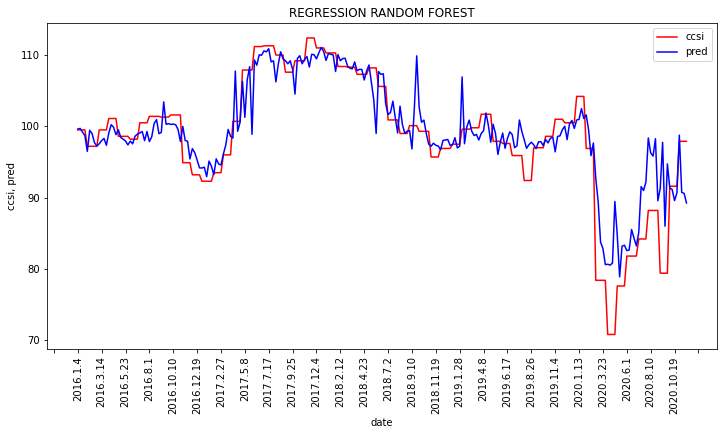

In [137]:
# 시계열 그래프를 그리기위해, 날짜 column 생성
tmp['date'] = tmp[['year', 'month', 'day']].apply(lambda x: '.'.join(map(str, x)), axis=1)

plt.rcParams["figure.figsize"] = (12, 6)
plt.plot(tmp['date'], tmp['ccsi'], color = 'red', label = 'ccsi')
plt.plot(tmp['date'], tmp['pred'], color = 'blue', label = 'pred')
plt.xlabel("date")
plt.ylabel("ccsi, pred")
ax = plt.subplot()
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
for label in ax.xaxis.get_ticklabels() :
    label.set_rotation(90)
plt.title("REGRESSION RANDOM FOREST")
plt.legend()
plt.show()

moving avg 시계열 그래프

<ipython-input-138-23773c3c32f0>:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot()


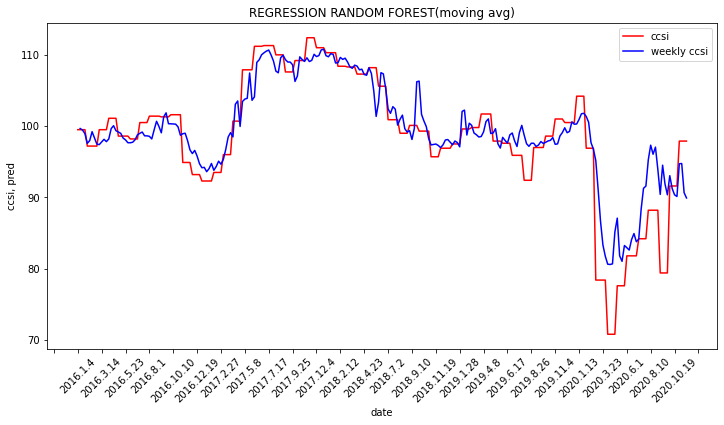

In [138]:
rolling = pd.Series.rolling(tmp['pred'], window = 2, center = False).mean()

plt.rcParams["figure.figsize"] = (12, 6)
plt.plot(tmp['date'], tmp['ccsi'], color = 'red', label = 'ccsi')
rolling.plot(color = 'blue', label = 'weekly ccsi')
plt.xlabel("date")
plt.ylabel("ccsi, pred")
ax = plt.subplot()
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
for label in ax.xaxis.get_ticklabels() :
    label.set_rotation(45)
plt.title("REGRESSION RANDOM FOREST(moving avg)")
plt.legend()
plt.show()

## Develop weekly CCSI(주간 경기선행지수)

In [139]:
weekly_CLI = []
for i in range(len(tmp)):
    if i == 0 :
        cli = tmp.pred.iloc[i]
        weekly_CLI.append(cli)
        continue
    
    cli = (tmp.pred.iloc[i-1] + tmp.pred.iloc[i]) / 2
    weekly_CLI.append(cli)
    
tmp['weeklyCLI'] = weekly_CLI
tmp

,year,month,day,keyword1,keyword2,keyword3,keyword4,keyword5,google,naver,id,ccsi,pred,date,weeklyCLI
0,2016,1,4,825,419,437,986,168,53.0,26.05846,91,99.5,99.617031,2016.1.4,99.617031
1,2016,1,11,770,348,351,626,182,56.0,25.16599,91,99.5,99.708125,2016.1.11,99.662578
2,2016,1,18,918,422,441,445,147,71.0,27.38639,91,99.5,99.188906,2016.1.18,99.448516
3,2016,1,25,1067,425,567,383,148,62.0,24.72622,91,99.5,98.687969,2016.1.25,98.938437
4,2016,2,1,899,341,485,289,110,54.0,23.01888,92,97.2,96.484687,2016.2.1,97.586328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,2020,10,26,992,198,178,187,114,76.0,30.24489,148,91.6,90.674375,2020.10.26,90.126875
252,2020,11,2,866,158,143,122,63,73.0,30.02069,149,97.9,98.766875,2020.11.2,94.720625
253,2020,11,9,907,150,141,137,95,81.0,30.88298,149,97.9,90.736563,2020.11.9,94.751719
254,2020,11,16,822,131,143,91,82,85.0,30.48202,149,97.9,90.597031,2020.11.16,90.666797
